In [1]:
from ultralytics import YOLO
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

import os
import csv

is_save = False
extract = True
device = 'cpu'

def crop_left(im): 
    return transforms.functional.crop(im, top=0, left=0, height=300, width=480)

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True).to(device)

# Remove classification head (if you only need features)
model.classifier = torch.nn.Identity()

model.eval()

/home/yigit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yigit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [2]:
t_steps = 400
dims = 1280#128 * 20 * 20
feats = torch.zeros(1, dims)
trajs = torch.zeros(1, t_steps, 3)

img_path = f'data/0/0/img.jpeg'
img = Image.open(img_path).convert('RGB')  # Load image using PIL
transform = transforms.Compose([
    transforms.Lambda(crop_left),  # Crop the left side
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    features = model(img) 
feats[0] = torch.flatten(features)

In [3]:
import sys
import torch
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns


folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnep import CNEP
from cnmp import CNMP

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [4]:
num_demos, v_num_demos = 1, 1
num_classes = 1  # Number of modes
num_indiv = num_demos // num_classes  # Number of trajectories per mode
num_val_indiv = v_num_demos // num_classes  # Number of trajectories per mode

dx = 1
dg = dims
dy = 3
batch_size = 1
n_max, m_max = 10, 10
t_steps = 400

In [5]:
obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx+dg), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = trajs[traj_id]
        feat = feats[traj_id]
        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)  # X
        obs[i, :n, dx:dx+dg] = feat.repeat(n, 1)  # G
        obs[i, :n, dx+dg:] = traj[n_ids]  # Y
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dx] = (m_ids/t_steps).unsqueeze(1)
        tar_x[i, :m, dx:] = feat.repeat(m, 1)
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = trajs[traj_id]
        feat = feats[traj_id]
        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        val_obs[i, :n, dx:dx+dg] = feat.repeat(n, 1)
        val_obs[i, :n, dx+dg:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i, :, :dx] = (m_ids/t_steps).unsqueeze(1)
        val_tar_x[i, :, dx:] = feat.repeat(t_steps, 1)
        val_tar_y[i] = traj[m_ids]

In [6]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_type = 'baxter/cnmp_cnep/'
test_path = 'mobile_net/1718629408/'
run_path = root_path + test_type + test_path

In [7]:
model_folder = 'saved_models/'
models_path = f'{run_path}{model_folder}'

cnep_path, cnmp_path = f'{models_path}last_cnep.pt', f'{models_path}last_cnmp.pt'

batch_size = 1
device = 'cpu'

cnep = CNEP(dx+dg, dy, n_max, n_max,  [512, 256], num_decoders=2, decoder_hidden_dims=[256,256], batch_size=batch_size, scale_coefs=True, device=device)
cnmp = CNMP(dx+dg, dy, n_max, m_max,  [512, 256], decoder_hidden_dims=[512,512], batch_size=batch_size, device=device)

cnep.load_state_dict(torch.load(cnep_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(cnmp_path, map_location='cpu'))

# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

In [8]:
t_steps = 400
val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)
###############
m = 1
val_obs_mask[0, :m] = True
val_tar_x[0, :, 0] = torch.linspace(0, 1, t_steps)
val_tar_x[0, :, 1:dx+dg] = feats[0].repeat(t_steps, 1)
###############
val_obs[0, 0, 0] = 0
val_obs[0, 0, 1:dx+dg] = feats[0]
val_obs[0, 0, dx+dg:] = torch.tensor([0.647001, -0.84109159,  0.04627661])
# val_obs[0, 1, 0] = 1
# val_obs[0, 1, 1:dx+dg] = feats[0]
# val_obs[0, 1, dx+dg:] = torch.tensor([0.45, -0.956, 0.02])


with torch.no_grad():
    pred_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)
    traj_cnmp = pred_cnmp[0, :, :dy]

    pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
    dec_id = torch.argmax(gate.squeeze(1), dim=-1)
    traj_cnep = pred_cnep[dec_id, 0, :, :dy].squeeze(0)

In [9]:
# load minmax values
if dy == 3:
    minmax = torch.load('minmax3.pt')
else:
    minmax = torch.load('minmax8.pt')
# denormalize each dimension in trajectories using corresponding minmax
for i in range(dy):
    traj_cnmp[:, i] = 0.5 * (traj_cnmp[:, i] + 1) * (minmax[i][1] - minmax[i][0]) + minmax[i][0]
    traj_cnep[:, i] = 0.5 * (traj_cnep[:, i] + 1) * (minmax[i][1] - minmax[i][0]) + minmax[i][0]


In [10]:
# interpolate traj_cnmp (400x3) to 1159x3 points
from scipy.interpolate import interp1d

t_steps_int = 1370
xnew = np.linspace(0, 1, t_steps_int)
x = np.linspace(0, 1, 400)

p = traj_cnmp.squeeze(0).cpu().numpy()
q = traj_cnep.squeeze(0).cpu().numpy()

p_interpolated = interp1d(x, p, axis=0, kind='linear')
p_new = p_interpolated(xnew)

q_interpolated = interp1d(x, q, axis=0, kind='linear')
q_new = q_interpolated(xnew)

traj_cnmp_interpolated = p_new
traj_cnep_interpolated = q_new

with open('data/current/cnmp.txt', 'w') as f:
    for i in range(t_steps_int):
        f.write(f'{traj_cnmp_interpolated[i, 0].item()},{traj_cnmp_interpolated[i, 1].item()},{traj_cnmp_interpolated[i, 2].item()}\n')

with open('data/current/cnep.txt', 'w') as f:
    for i in range(t_steps_int):
        f.write(f'{traj_cnep_interpolated[i, 0].item()},{traj_cnep_interpolated[i, 1].item()},{traj_cnep_interpolated[i, 2].item()}\n')

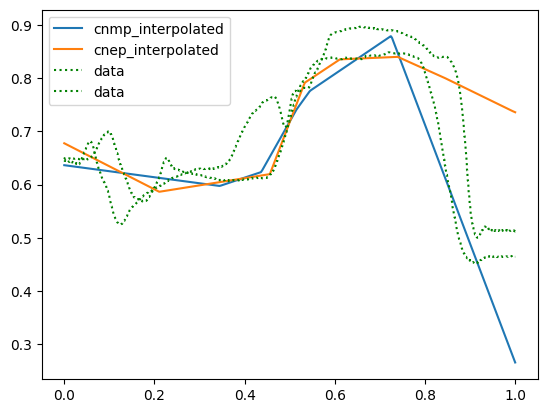

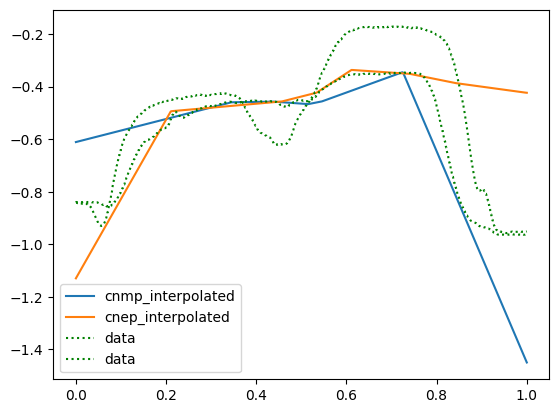

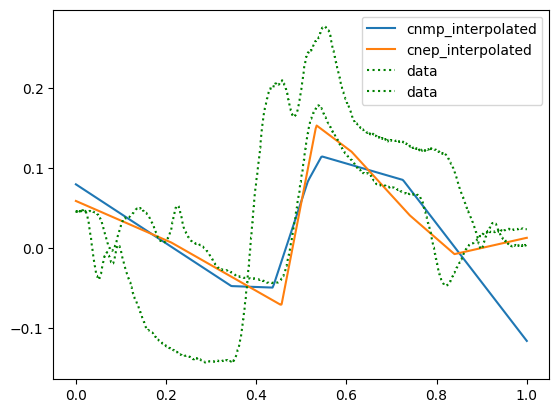

In [12]:
data_folder0 = f'/home/yigit/projects/cnep/baxter/data/0/0/'
# iterate over all files in the data_folder
for filename in os.listdir(data_folder0):
    d = os.path.join(data_folder0, filename)
    if filename.endswith('.csv'):
        temp_data0 = []
        with open(d, 'r') as f:
            for j, line in enumerate(csv.reader(f)):
                if j > 0:
                    # temp_data0.append([float(line[3]), float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[8]), float(line[9]), (float(line[10])/50)-1])  # p, q, gripper
                    temp_data0.append([float(line[3]), float(line[4]), float(line[5])])  # p

data_folder1 = f'/home/yigit/projects/cnep/baxter/data/1/0/'
# iterate over all files in the data_folder
for filename in os.listdir(data_folder1):
    d = os.path.join(data_folder1, filename)
    if filename.endswith('.csv'):
        temp_data1 = []
        with open(d, 'r') as f:
            for j, line in enumerate(csv.reader(f)):
                if j > 0:
                    # temp_data1.append([float(line[3]), float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[8]), float(line[9]), (float(line[10])/50)-1])  # p, q, gripper
                    temp_data1.append([float(line[3]), float(line[4]), float(line[5])])  # p



# plot traj_cnep[0, :, 0] in torch.linspace(0, 1, t_steps) and traj_cnep_interpolated[:, 0] in torch.linspace(0, 1, t_steps_int) and temp_data[:, 0] in torch.linspace(0, 1, len(temp_data))
# plt.plot(torch.linspace(0, 1, t_steps), traj_cnep[0, :, 0], label='cnep', linestyle='--')
for i in range(3):
    if i==0:
        plt.ylim(-0.2, 1.2)
    elif i==1:
        plt.ylim(-1.5, 0.1)
    elif i==2:
        plt.ylim(-0.6, 0.8)
    plt.plot(torch.linspace(0, 1, t_steps_int), traj_cnmp_interpolated[:, i], label='cnmp_interpolated')
    plt.plot(torch.linspace(0, 1, t_steps_int), traj_cnep_interpolated[:, i], label='cnep_interpolated')
    plt.plot(torch.linspace(0, 1, len(temp_data0)), [x[i] for x in temp_data0], label='data', linestyle=':', color='green')
    plt.plot(torch.linspace(0, 1, len(temp_data1)), [x[i] for x in temp_data1], label='data', linestyle=':', color='green')
    plt.legend()
    plt.show()

# for i in range(3):
#     plt.plot(torch.linspace(0, 1, t_steps), traj_cnmp[:, i], label='cnmp')
#     plt.plot(torch.linspace(0, 1, t_steps), traj_cnep[:, i], label='cnep')
#     plt.plot(torch.linspace(0, 1, len(temp_data)), [x[i] for x in temp_data], label='data', linestyle=':')
#     plt.legend()
#     plt.show()